In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config Completer.use_jedi = False

In [3]:
import sys, os
sys.path.append('../SelectionFunctionToolkit')

### Check selection function

In [4]:
import matplotlib.pyplot as plt, matplotlib
import numpy as np, healpy as hp, h5py
from scipy import stats, special, linalg, optimize
import scipy
import tqdm
from astropy.coordinates import SkyCoord

from pylab import cm

# Plotting modules
import matplotlib
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Arrow, FancyArrow
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=24)
plt.rc('xtick',labelsize=24)
plt.rc('ytick',labelsize=24)
plt.rc('legend',fontsize=24)
plt.rc('font',size=24)

In [5]:
import warnings
warnings.filterwarnings("ignore", message="You are modifying the state of a globally registered colormap.")
warnings.filterwarnings("ignore", message="Passing parameters norm and vmin/vmax simultaneously is deprecated")
warnings.filterwarnings("ignore", message="divide by zero encountered")
warnings.filterwarnings("ignore", message="overflow encountered in exp")

In [6]:
def add_log_cbar(ax, vmin=0., vmax=1., cmap='viridis',
             orientation='vertical', ticks=[0,1], tick_labels=['0','1']):

    norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
    im = plt.cm.ScalarMappable(norm=norm, cmap=cmap); im.set_array([])

    tick_pos = (np.log(np.array(ticks)) - np.log(vmin))/(np.log(vmax)-np.log(vmin))
    cbar = plt.colorbar(im, cax=ax, orientation=orientation, ticks=tick_pos)

    if orientation=='vertical':
        cbar.ax.set_yticklabels(tick_labels)
    else:
        cbar.ax.set_xticklabels(tick_labels)
    #print(tick_pos, tick_labels)

    return cbar

def plothist(values, bins, density=False, count=None, **kwargs):
    if count==None:
        count=len(values)
        
    y = np.histogram(values, bins)[0].astype(float)
    if density: y /= ((bins[1:]-bins[:-1]) * count)
    
    x = np.repeat(bins,2)
    y = np.insert(np.repeat(y,2), (0,len(y)*2), (0,0))
    
    plt.plot(x,y,**kwargs)
    
def logit(p):
    return np.log(p/(1-p))
def expit(x):
    return 1/(1+np.exp(-x))

In [7]:
%config Completer.use_jedi = False

# Minmax of data

In [8]:
sys.path.append('/home/andy/Documents/software/')
import getdata, sqlutilpy
query = """select min(phot_g_mean_mag) as min_g, max(phot_g_mean_mag) as max_g,
                  min(bp_rp) as min_c, max(bp_rp) as max_c
        from gaia_edr3.gaia_source
        where phot_g_mean_mag is not null
            and astrometric_params_solved>3
            and dr2_rv_nb_transits>3
            and bp_rp is not NULL"""
%time minmax = sqlutilpy.get(query,asDict=True,**getdata.sql_args)
print(minmax)

CPU times: user 72 ms, sys: 28 ms, total: 100 ms
Wall time: 16min 46s
OrderedDict([('min_g', array([3.5165603], dtype=float32)), ('max_g', array([17.085093], dtype=float32)), ('min_c', array([-0.1259861], dtype=float32)), ('max_c', array([8.46481], dtype=float32))])


## Load in selection function

In [8]:
from selectionfunctions.config import config
config['data_dir'] = '/data/asfe2/Projects/astrometry/PyOutput/'

In [9]:
from selectionfunctions.carpentry import chisel
from selectionfunctions.source import Source
import astropy.units as units
from selectionfunctions.std_paths import data_dir

In [16]:
M = 62; C = 10; nside=64; jmax=5; B=2.; lm=0.6; lc=0.6
run_name = f"chisquare_rvs_jmax{jmax}_nside{nside}_M{M}_CGR{C}_lm{lm}lc{lc}_B{B}_ncores88"
basis_options = {'needlet':'chisquare', 'j':jmax, 'B':B, 'p':1.0, 'wavelet_tol':1e-2}
sigma = [-0.81489922, -2.55429039]

map_fname = run_name + "_scipy_results.h5"

In [17]:
rvs_sf = chisel(map_fname=map_fname, nside=64, C=C, M=M, basis_options=basis_options,
                lengthscale_m=1.5, lengthscale_c=1.5,
                spherical_basis_directory='/data/asfe2/Projects/astrometry/SphericalWavelets/')

Loading auxilliary data ...


/home/andy/py36/lib/python3.6/site-packages/selectionfunctions/SelectionFunctionUtils.py:99: RuntimeWarning: overflow encountered in power
  u = l*(l+1) / np.power(self.B,2.0*j)


Spherical Basis: wavelet_chisquare_nside64_B2.0_p1.0_tol0.01_j[-1,0,1,2,3,4,5].h5
Spherical basis file loaded
t = 3.257 s
  auxilliary:   0.778 s
          sf:   0.000 s
interpolator:   2.479 s


In [12]:
hp.max_pixrad(32, degrees=True)

1.902601860011511

## Data

In [18]:
_downgrade = lambda A: A.reshape(M, A.shape[0]//M, 
                                 C, A.shape[1]//C, 
                                 hp.nside2npix(nside), A.shape[2]//hp.nside2npix(nside)).sum(axis=(1,3,5))

In [20]:
eps=1e-10

Mlims = [5.,17.4]; Clims = [-1,3];

colour=True
mag_res = 0.2;
M_bins = np.arange(Mlims[0], Mlims[1]+eps, mag_res)
col_res = 0.2;
C_bins = np.arange(Clims[0], Clims[1]+eps, col_res)

data_M=int((Mlims[1]-Mlims[0])/mag_res + eps);
data_C=int((Clims[1]-Clims[0])/col_res + eps);
data_nside = pow(2,7)
data_res=(data_M, data_C, hp.nside2npix(data_nside))
print('data_res: ', data_res)
sample="rvs"; file="Gres5CRres5hpx7" #file="Gres10CRres2hpx7"; 
box={};
with h5py.File(f'/data/asfe2/Projects/astrometry/gaiaedr3_{sample}_kncounts_{file}.h', 'r') as hf:
    box['n'] = np.zeros(data_res, dtype=np.int64)
    box['k'] = np.zeros(data_res, dtype=np.int64)

    Midx = hf['magnitude'][...] - int(Mlims[0]/mag_res + eps)
    try: Cidx = hf['colour'][...] - int(Clims[0]/col_res + eps)
    except KeyError: Cidx = np.zeros(len(Midx), dtype=np.int64)
    Pidx = hf['position'][...]
    in_range = (Midx>-1)&(Midx<data_M)&(Cidx>-1)&(Cidx<data_C)
    for key in ['n','k']:
        box[key][Midx[in_range], Cidx[in_range], Pidx[in_range]] = hf[key][...][in_range]
print(box['n'].shape)

data_res:  (62, 20, 196608)
(62, 20, 196608)


In [21]:
box['n']=_downgrade(box['n'])
box['k']=_downgrade(box['k'])

M_bins = np.linspace(*Mlims, M+1)
C_bins = np.linspace(*Clims, C+1)

# Beta distribution tests of Comparison

In [36]:
g = [10.1,13.1,16.1]
c = 0.8

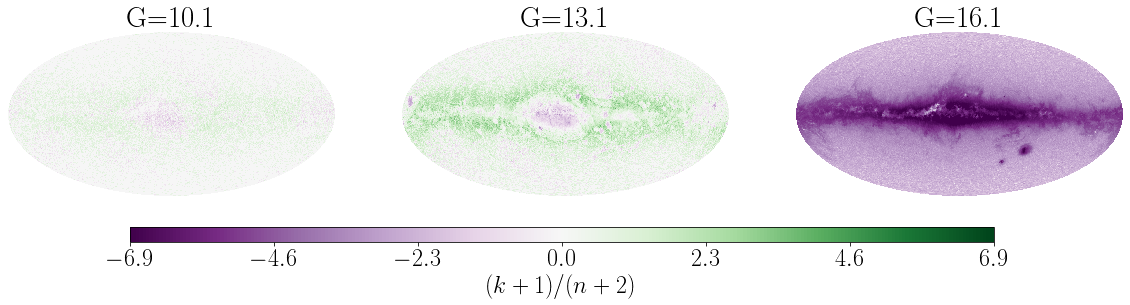

In [37]:
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,3,figsize=(20,5))
minmax=[-6.9,6.9]
for i in range(3):
    plt.sca(axes[i])
    g_idx = np.sum(M_bins<g[i])-1
    c_idx = np.sum(C_bins<c)-1
    expected = (box['k'][g_idx,c_idx]+1)/(box['n'][g_idx,c_idx]+2)
    hp.mollview(logit(expected), nest=True, notext=True,min=minmax[0],max=minmax[1],
                coord=['C','G'], title='G=%.1f'%g[i], cmap='PRGn', hold=True, cbar=False, xsize=2000)
#     print()

ax = fig.add_axes([0.21, 0.15, 0.6, 0.04]); 
norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='PRGn'); im.set_array([])
cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=np.arange(-6.9,7.,2.3))
cbar.set_label(r'$(k+1)/(n+2)$', fontsize=24)

# plt.savefig('figs/rvs/%s_expected-x_3hpx.png' % run_name, bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

# Load in full pixel selection function

In [24]:
sf_box = {}
with h5py.File(os.path.join(data_dir(),map_fname), 'r') as f:
    sf_box['x'] = f['x'][...]
    sf_box['b'] = f['b'][...]
    sf_box['z'] = f['z'][...]
    M_bins = np.linspace(*f['Mlim'][...], M+1)
    C_bins = np.linspace(*f['Clim'][...], C+1)

In [25]:
i=1
print(np.std(sf_box['z']))
print(np.std(sf_box['z'][0]))
for j in range(1,jmax+1):
    print(j, np.std(sf_box['z'][i:i+hp.nside2npix(j)]))
    i+=hp.nside2npix(j)
np.min(sf_box['z']), np.max(sf_box['z'])

0.10499526560560604
2.197352240962432
1 0.15058907252177747
2 0.24753255813500624
3 0.17645136377976647
4 0.14727687415094393
5 0.10736875030314594


(-16.86342980393501, 6.52028845769029)

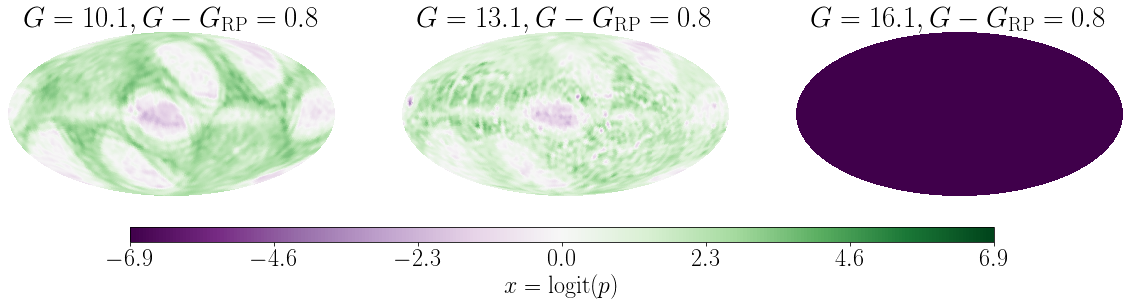

In [38]:
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,3,figsize=(20,5))
minmax=[-6.9,6.9]
for i in range(3):
    plt.sca(axes[i])
    g_idx = np.sum(M_bins<g[i])-1
    c_idx = np.sum(C_bins<c)-1
    hp.mollview(sf_box['x'][g_idx,c_idx], nest=True, notext=True,min=minmax[0],max=minmax[1],
                coord=['C','G'], title=fr'$G={g[i]:.1f}, G-G_\mathrm{{RP}}={c:.1f}$', cmap='PRGn', hold=True, cbar=False, xsize=2000)
#     print()

ax = fig.add_axes([0.21, 0.15, 0.6, 0.04]); 
norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='PRGn'); im.set_array([])
cbar = plt.colorbar(im, cax=ax, orientation='horizontal', 
                    ticks=np.arange(-6.9,7.,2.3))
cbar.set_label(r'$x = \mathrm{logit}(p)$', fontsize=24)

plt.savefig('figs/rvs/%s_x_3hpx.png' % run_name, bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

In [45]:
M_bins

array([ 5. ,  5.2,  5.4,  5.6,  5.8,  6. ,  6.2,  6.4,  6.6,  6.8,  7. ,
        7.2,  7.4,  7.6,  7.8,  8. ,  8.2,  8.4,  8.6,  8.8,  9. ,  9.2,
        9.4,  9.6,  9.8, 10. , 10.2, 10.4, 10.6, 10.8, 11. , 11.2, 11.4,
       11.6, 11.8, 12. , 12.2, 12.4, 12.6, 12.8, 13. , 13.2, 13.4, 13.6,
       13.8, 14. , 14.2, 14.4, 14.6, 14.8, 15. , 15.2, 15.4, 15.6, 15.8,
       16. , 16.2, 16.4, 16.6, 16.8, 17. , 17.2, 17.4])

In [43]:
C_bins

array([-1. , -0.6, -0.2,  0.2,  0.6,  1. ,  1.4,  1.8,  2.2,  2.6,  3. ])

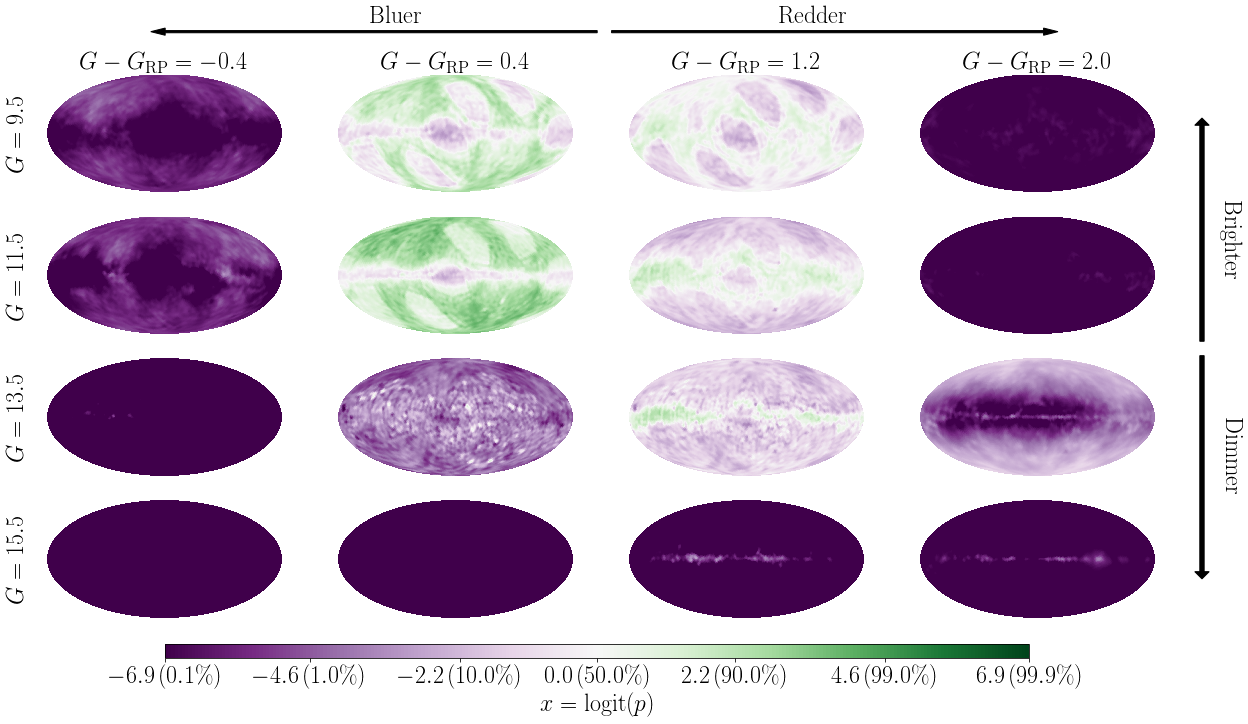

In [44]:
g = [9.5,11.5,13.5,15.5]
c = [-0.4,0.4,1.2,2.]

#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(4,4,figsize=(20,10))

minmax=[np.log(1/999),np.log(0.999/0.001)]
for i in range(4):
    for j in range(4):
        plt.sca(axes[i,j])
        g_idx = np.sum(M_bins<g[i])-1
        c_idx = np.sum(C_bins<c[j])-1
        hp.mollview(sf_box['x'][g_idx,c_idx], nest=True, notext=True,min=minmax[0],max=minmax[1],
                    coord=['C','G'], title='', cmap='PRGn', hold=True, cbar=False, xsize=2000)
        if j==0: plt.text(-2.5,0.,fr'$G={g[i]:.1f}$',ha='center', va='center', rotation='vertical')
        if i==0: plt.text(0.,1.2,fr'$G-G_\mathrm{{RP}}={c[j]:.1f}$', va='center', ha='center')

arrow_kwargs = dict(fc='k', ec='k', width=0.003, head_length=0.01, head_width=0.01)
arrow_red = FancyArrow(0.51, 0.94, -0.3, 0., **arrow_kwargs); fig.add_artist(arrow_red)
fig.text(0.66, 0.96,'Redder',ha='center', va='center', rotation=0)
arrow_blue = FancyArrow(0.52, 0.94, 0.3, 0., **arrow_kwargs); fig.add_artist(arrow_blue)
fig.text(0.37, 0.96,'Bluer',ha='center', va='center', rotation=0)
arrow_bright = FancyArrow(0.93, 0.51, 0., 0.3, **arrow_kwargs); fig.add_artist(arrow_bright)
fig.text(.95, 0.65,'Brighter',ha='center', va='center', rotation=270)
arrow_dim = FancyArrow(0.93, 0.49, 0., -0.3, **arrow_kwargs); fig.add_artist(arrow_dim)
fig.text(.95, 0.35,'Dimmer',ha='center', va='center', rotation=270)

    
ax = fig.add_axes([0.21, 0.07, 0.6, 0.02]); 
norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='PRGn'); im.set_array([])
p=np.array([0.001,0.01,0.1,0.5,0.9,0.99,0.999]); ticks=np.log(p/(1-p))
tick_labels = [rf"${ticks[i]:.1f}\,({p[i]*100:.1f}\%)$" for i in range(len(p))]
cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=ticks)
cbar.set_ticklabels(tick_labels)
cbar.set_label(r'$x = \mathrm{logit}(p)$', fontsize=24)

plt.savefig('figs/rvs/%s_x_16hpx.png' % run_name, bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

# Binomial

## P-value of k

$$ p_\mathrm{value} \sim U[I_{k-1}, I_k]$$

$$ I_k = \sum_{j=0}^{k} \mathrm{Binomial}(\,j\,;\, n,\,p) $$

In [28]:
g = [9.51,11.51,13.51,15.51]; 
c=0.8

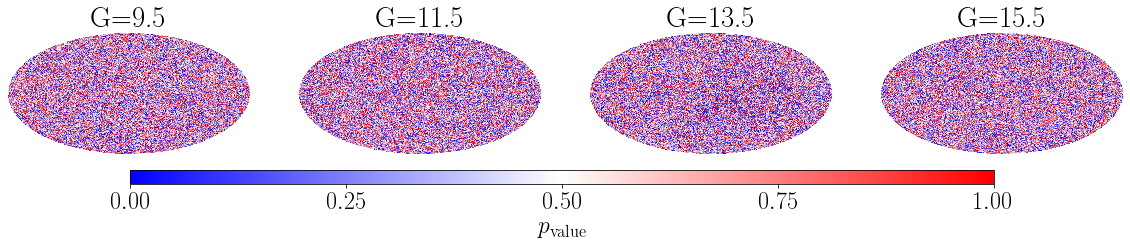

In [30]:
fig, axes = plt.subplots(1,4,figsize=(20,5))
minmax=[0.,1.]
for i in range(4):
    plt.sca(axes[i])
    g_idx = np.sum(M_bins<g[i])-1
    c_idx = np.sum(C_bins<c)-1
    pval_k = scipy.stats.binom.cdf(box['k'][g_idx,c_idx], box['n'][g_idx,c_idx], expit(sf_box['x'][g_idx,c_idx]))
    pval_km1 = scipy.stats.binom.cdf(box['k'][g_idx,c_idx]-1, box['n'][g_idx,c_idx], expit(sf_box['x'][g_idx,c_idx]))
    pvals = np.random.rand(len(pval_k))*(pval_k - pval_km1) + pval_km1
    
    hp.mollview(pvals, nest=True, notext=True,min=minmax[0],max=minmax[1],
                coord=['C','G'], title='G=%.1f'%g[i], cmap='bwr', hold=True, cbar=False, xsize=2000)

ax = fig.add_axes([0.21, 0.25, 0.6, 0.04]); 
norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='bwr'); im.set_array([])
cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=np.arange(0,1.01,0.25))
cbar.set_label(r'$p_\mathrm{value}$')

plt.savefig(f'figs/rvs/{run_name}_c{c:.1f}_binompval_4hpx.png', bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

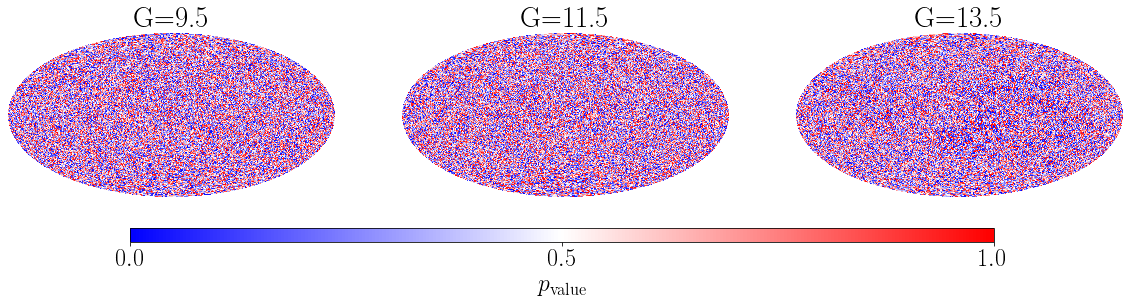

In [31]:
fig, axes = plt.subplots(1,3,figsize=(20,5))
minmax=[0.,1.]
for i in range(3):
    plt.sca(axes[i])
    g_idx = np.sum(M_bins<g[i])-1
    c_idx = np.sum(C_bins<c)-1
    pval_k = scipy.stats.binom.cdf(box['k'][g_idx,c_idx], box['n'][g_idx,c_idx], expit(sf_box['x'][g_idx,c_idx]))
    pval_km1 = scipy.stats.binom.cdf(box['k'][g_idx,c_idx]-1, box['n'][g_idx,c_idx], expit(sf_box['x'][g_idx,c_idx]))
    pvals = np.random.rand(len(pval_k))*(pval_k - pval_km1) + pval_km1
    
    hp.mollview(pvals, nest=True, notext=True,min=minmax[0],max=minmax[1],
                coord=['C','G'], title='G=%.1f'%g[i], cmap='bwr', hold=True, cbar=False, xsize=2000)

ax = fig.add_axes([0.21, 0.15, 0.6, 0.04]); 
norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='bwr'); im.set_array([])
cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=[minmax[0], 0.5, minmax[1]])
cbar.set_label(r'$p_\mathrm{value}$', fontsize=24)

plt.savefig('figs/rvs/%s_binompval_3hpx.png' % run_name, bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

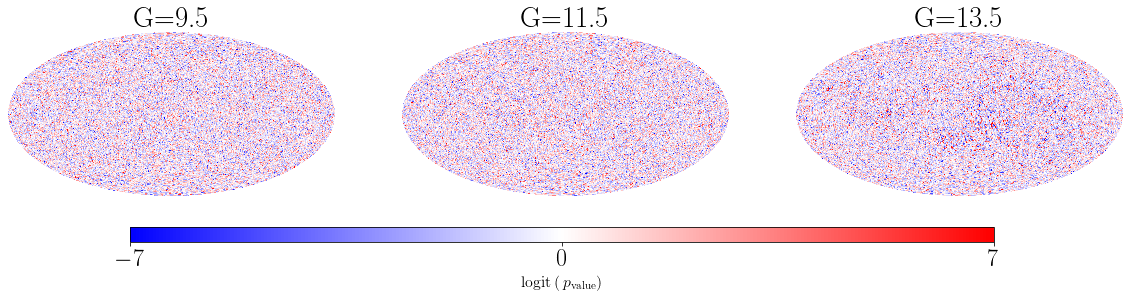

In [32]:
#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig, axes = plt.subplots(1,3,figsize=(20,5))
minmax=[-7,7]
for i in range(3):
    plt.sca(axes[i])
    g_idx = np.sum(M_bins<g[i])-1
    c_idx = np.sum(C_bins<c)-1
    pval_k = scipy.stats.binom.cdf(box['k'][g_idx,c_idx], box['n'][g_idx,c_idx], expit(sf_box['x'][g_idx,c_idx]))
    pval_km1 = scipy.stats.binom.cdf(box['k'][g_idx,c_idx]-1, box['n'][g_idx,c_idx], expit(sf_box['x'][g_idx,c_idx]))
    pvals = np.random.rand(len(pval_k))*(pval_k - pval_km1) + pval_km1
    
    hp.mollview(logit(pvals), nest=True, notext=True,min=minmax[0],max=minmax[1],
                coord=['C','G'], title='G=%.1f'%g[i], cmap='bwr', hold=True, cbar=False, xsize=2000)
#     print()

ax = fig.add_axes([0.21, 0.15, 0.6, 0.04]); 
norm = matplotlib.colors.Normalize(vmin=minmax[0], vmax=minmax[1])
im = plt.cm.ScalarMappable(norm=norm, cmap='bwr'); im.set_array([])
cbar = plt.colorbar(im, cax=ax, orientation='horizontal', ticks=[minmax[0], 0., minmax[1]])
cbar.set_label(r'$\mathrm{logit}\left(\,p_\mathrm{value}\right)$', fontsize=16)

plt.savefig('figs/rvs/%s_logit-binompval_3hpx.png' % run_name, bbox_inches='tight', dpi=200, facecolor='w', transparent=False)

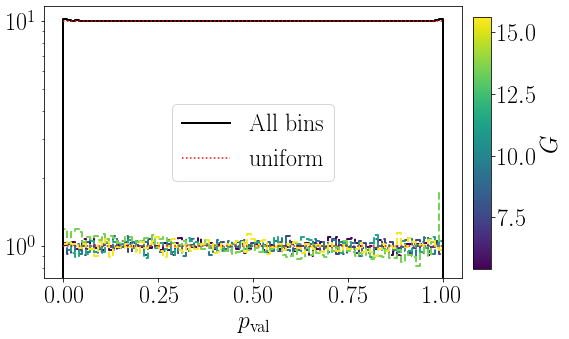

In [33]:
g = np.arange(5.5,16.6,2.)

#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig = plt.figure(figsize=(8,5))

cmap = cm.viridis; mmin=np.min(g)-0.1; mmax=np.max(g)+0.1

for i in range(len(g)):
    g_idx = np.sum(M_bins<g[i])-1
    c_idx = np.sum(C_bins<c)-1
    pval_k = scipy.stats.binom.cdf(box['k'][g_idx,c_idx], box['n'][g_idx,c_idx], expit(sf_box['x'][g_idx,c_idx]))
    pval_km1 = scipy.stats.binom.cdf(box['k'][g_idx,c_idx]-1, box['n'][g_idx,c_idx], expit(sf_box['x'][g_idx,c_idx]))
    pvals = np.random.rand(len(pval_k))*(pval_k - pval_km1) + pval_km1
    plothist(pvals, bins=np.linspace(0,1,100), density=True,
            color=cmap((g[i]-mmin)/(mmax-mmin)), linewidth=2, linestyle='--')
    

pval_k = scipy.stats.binom.cdf(box['k'], box['n'], expit(sf_box['x']))
pval_km1 = scipy.stats.binom.cdf(box['k']-1, box['n'], expit(sf_box['x']))
pvals = np.random.rand(*pval_k.shape)*(pval_k - pval_km1) + pval_km1
plothist(pvals.flatten(), bins=np.linspace(0,1,100), label='All bins', 
        color='k', linewidth=2, density=True, count=len(pvals.flatten())/10)

plt.yscale('log')
plt.xlabel(r'$p_\mathrm{val}$', fontsize=24)


plt.plot([0,1], [1,1], ':r', label='uniform')
plt.plot([0,1], [10,10], ':r')
#plt.plot(x, scipy.stats.logistic.pdf(x)*10, '--r')

plt.legend(loc='center')

# Adding cbar axes to subplots
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
norm = matplotlib.colors.Normalize(vmin=mmin,vmax=mmax)
im = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$G$', fontsize=24)
plt.savefig('figs/rvs/%s_binompval_logithist.png' % run_name, bbox_inches='tight', dpi=100, facecolor='w', transparent=False)

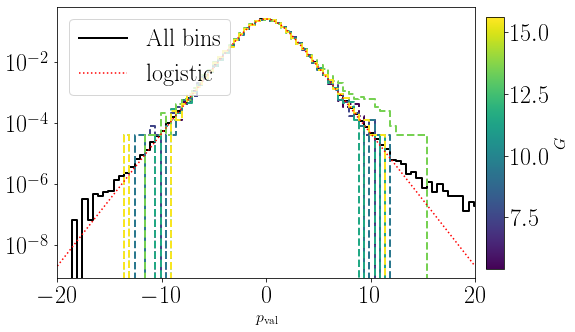

In [34]:
g = np.arange(5.5,16.6,2.)

#cmap = copy.copy(mpl.cm.get_cmap("viridis"))
fig = plt.figure(figsize=(8,5))

cmap = cm.viridis; mmin=np.min(g)-0.1; mmax=np.max(g)+0.1

pval_k = scipy.stats.binom.cdf(box['k'], box['n'], expit(sf_box['x']))
pval_km1 = scipy.stats.binom.cdf(box['k']-1, box['n'], expit(sf_box['x']))
pvals = np.random.rand(*pval_k.shape)*(pval_k - pval_km1) + pval_km1
minmax = np.round(np.min(logit(pvals)[~np.isinf(logit(pvals))]), decimals=1)-1.,\
         np.round(np.max(logit(pvals)[~np.isinf(logit(pvals))]), decimals=1)+1.
bins = np.arange(minmax[0], minmax[1]+1e-10, 0.5)
    
pvals[pvals==0.] = expit(minmax[0]+0.05); pvals[pvals==1.] = expit(minmax[1]-0.05)
plothist(logit(pvals.flatten()), bins=bins, label='All bins',
        color='k', linewidth=2, density=True, count=len(pvals.flatten()))

for i in range(len(g)):
    g_idx = np.sum(M_bins<g[i])-1
    c_idx = np.sum(C_bins<c)-1
    pval_k = scipy.stats.binom.cdf(box['k'][g_idx,c_idx], box['n'][g_idx,c_idx], expit(sf_box['x'][g_idx,c_idx]))
    pval_km1 = scipy.stats.binom.cdf(box['k'][g_idx,c_idx]-1, box['n'][g_idx,c_idx], expit(sf_box['x'][g_idx,c_idx]))
    pvals = np.random.rand(len(pval_k))*(pval_k - pval_km1) + pval_km1
    pvals[logit(pvals)<minmax[0]] = expit(minmax[0]+0.05); 
    pvals[logit(pvals)>minmax[1]] = expit(minmax[1]-0.05)
    plothist(logit(pvals), bins=bins,
        color=cmap((g[i]-mmin)/(mmax-mmin)), linewidth=2, linestyle='--', density=True)

plt.yscale('log')
plt.xlabel(r'$p_\mathrm{val}$', fontsize=16)

plt.xlim(-20,20)

x = np.linspace(-20,20,100)
plt.plot(x, scipy.stats.logistic.pdf(x), ':r', label='logistic')
#plt.plot(x, scipy.stats.logistic.pdf(x)*10, '--r')

plt.legend(loc='upper left')

# Adding cbar axes to subplots
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])
norm = matplotlib.colors.Normalize(vmin=mmin,vmax=mmax)
im = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$G$', fontsize=16)

plt.savefig('figs/rvs/%s_binompval_logithist.png' % run_name, bbox_inches='tight', dpi=100, facecolor='w', transparent=False)

# Using GP on b

/home/andy/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':


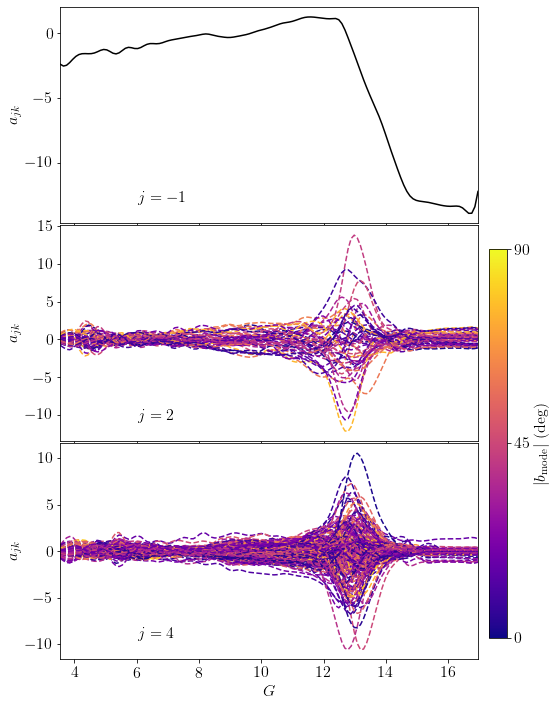

In [39]:
fig, axes = plt.subplots(3,1,figsize=(8,12), sharex=True)

g = (M_bins[1:]+M_bins[:-1])/2
cmap = cm.plasma
#logsd_min, logsd_max = np.log10(sd_target)[[0,-1]]

j_vals = [-1,2,4]
sigma = [-0.81489922, -2.55429039]
prior_std = np.sqrt(np.exp(sigma[0])*np.power(np.array(j_vals),sigma[1]))
imode=0

for i, _j in enumerate(j_vals):
    plt.sca(axes[i])
    if _j==-1:
        plt.plot(g, sf_box['b'][imode,:,0], '-k')#, color=cmap((_m+_l)/(2*_l)))
        imode+=1
    else:
        ra,dec = hp.pix2ang(_j, np.arange(hp.nside2npix(_j)), nest=False, lonlat=True)
        c = SkyCoord(ra, dec, unit='deg', frame='icrs')
        l = c.galactic.l.deg
        b = c.galactic.b.deg
        for _m in range(hp.nside2npix(_j)):
            plt.plot(g, sf_box['b'][imode,:,0], '--', color=cmap((np.abs(b[_m]))/90))
            imode+=1

    #plt.ylabel(r'$a_{lm}\,/\,\left(A(l+1)^{\gamma}\right)$')

    ylim = axes[i].get_ylim()
    plt.text(6., (ylim[1]-ylim[0])*0.1 + ylim[0], r"$j=%d$" % _j)
    plt.ylabel(r'$a_{jk}$')
    
# Adding cbar axes to subplots
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.45])
norm = matplotlib.colors.Normalize(vmin=0,vmax=90)
im = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax, ticks=[0,45,90])
cbar.set_label(r'$|b_\mathrm{mode}|$ (deg)', fontsize=16)
    
plt.sca(axes[2])
plt.xlabel(r'$G$'); 
plt.xlim(np.min(g), np.max(g))

plt.subplots_adjust(hspace=0.01)

#plt.savefig('figs/%s_b-vs-mag_3l_m.png' % run_name, bbox_inches='tight', facecolor='w', transparent=False)

In [65]:
g = np.linspace(M_bins[0], M_bins[-1],500)
col = np.zeros(len(g))+2.

# Contstruct covariance kernel for new positions.
KmM = rvs_sf.covariance_kernel(g, rvs_sf.Mcenters, lengthscale=rvs_sf.lengthscale_m)
KcC = rvs_sf.covariance_kernel(col, rvs_sf.Ccenters, lengthscale=rvs_sf.lengthscale_c)

# Estimate alm using Gaussian Process
_b = np.sum ( ((KmM @ rvs_sf._inv_KMM) @ rvs_sf.b) * (KcC @ rvs_sf._inv_KCC)[None, :,:] , axis=2)

/home/andy/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in power
  


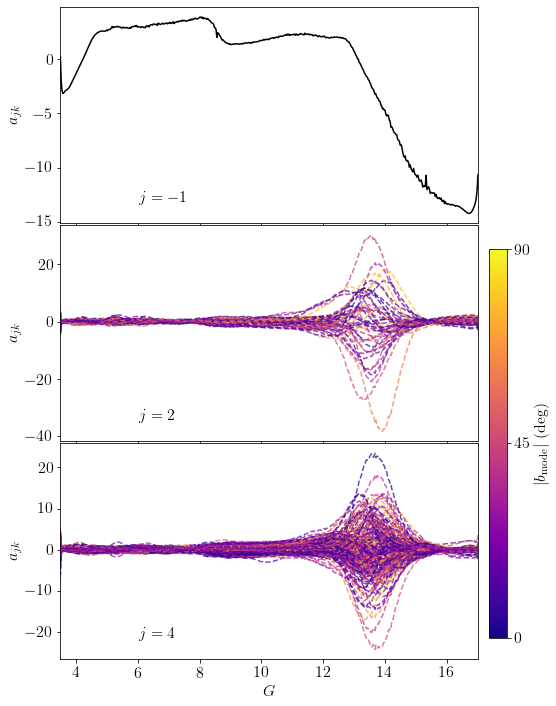

In [72]:
fig, axes = plt.subplots(3,1,figsize=(8,12), sharex=True)

cmap = cm.plasma
#logsd_min, logsd_max = np.log10(sd_target)[[0,-1]]

j_vals = [-1,2,4]
sigma = [-0.81489922, -2.55429039]
prior_std = np.sqrt(np.exp(sigma[0])*np.power(np.array(j_vals),sigma[1]))
imode=0

for i, _j in enumerate(j_vals):
    plt.sca(axes[i])
    if _j==-1:
        #plt.plot(g, _b[imode]/pychisel.sigma[imode], '-k')#, color=cmap((_m+_l)/(2*_l)))
        plt.plot(g, _b[imode], '-k')#, color=cmap((_m+_l)/(2*_l)))
        imode+=1
    else:
        ra,dec = hp.pix2ang(_j, np.arange(hp.nside2npix(_j)), nest=False, lonlat=True)
        c = SkyCoord(ra, dec, unit='deg', frame='icrs')
        l = c.galactic.l.deg
        b = c.galactic.b.deg
        for _m in range(hp.nside2npix(_j)):
            #plt.plot(g, _b[imode]/pychisel.sigma[imode], '--', color=cmap((np.abs(b[_m]))/90))
            plt.plot(g, _b[imode], '--', color=cmap((np.abs(b[_m]))/90), alpha=0.7)
            imode+=1

    #plt.ylabel(r'$a_{lm}\,/\,\left(A(l+1)^{\gamma}\right)$')

    ylim = axes[i].get_ylim()
    plt.text(6., (ylim[1]-ylim[0])*0.1 + ylim[0], r"$j=%d$" % _j)
    plt.ylabel(r'$a_{jk}$')
    
# Adding cbar axes to subplots
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.45])
norm = matplotlib.colors.Normalize(vmin=0,vmax=90)
im = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax, ticks=[0,45,90])
cbar.set_label(r'$|b_\mathrm{mode}|$ (deg)', fontsize=16)
    
plt.sca(axes[2])
plt.xlabel(r'$G$'); 
plt.xlim(np.min(g), np.max(g))

plt.subplots_adjust(hspace=0.01)

#plt.savefig('figs/%s_GP_b-vs-mag_3l_m.png' % run_name, bbox_inches='tight', facecolor='w', transparent=False)

## Power spectrum

In [148]:
eps=1e-10

ncores=20
Mlims = [4,17]; Clims = [-1,5];

colour=True
mag_res = 0.1;
M_bins = np.arange(Mlims[0], Mlims[1]+eps, mag_res)
col_res = 0.5;
C_bins = np.arange(Clims[0], Clims[1]+eps, col_res)

data_M=int((Mlims[1]-Mlims[0])/mag_res + eps);
data_C=int((Clims[1]-Clims[0])/col_res + eps);
data_nside = pow(2,7)
data_res=(data_M, data_C, hp.nside2npix(data_nside))
print('data_res: ', data_res)
sample="rvs"; file="Gres10Cres2hpx7"
box={};
with h5py.File(f'/data/asfe2/Projects/astrometry/gaiaedr3_{sample}_kncounts_{file}.h', 'r') as hf:
    box['n'] = np.zeros(data_res, dtype=np.int64)
    box['k'] = np.zeros(data_res, dtype=np.int64)

    Midx = hf['magnitude'][...] - int(Mlims[0]/mag_res + eps)
    try: Cidx = hf['colour'][...] - int(Clims[0]/col_res + eps)
    except KeyError: Cidx = np.zeros(len(Midx), dtype=np.int64)
    Pidx = hf['position'][...]
    in_range = (Midx>-1)&(Midx<data_M)&(Cidx>-1)&(Cidx<data_C)
    for key in ['n','k']:
        box[key][Midx[in_range], Cidx[in_range], Pidx[in_range]] = hf[key][...][in_range]
print(box['n'].shape)

data_res:  (130, 12, 196608)
(130, 12, 196608)


In [149]:
np.sum(box['n'])

150435265

In [150]:
nside=128; M=13; C=3
box['n'] = _downgrade(box['n'])
box['k'] = _downgrade(box['k'])

In [152]:
lmax=200
x = logit((box['k']+1)/(box['n']+2))
spectrum = hp.anafast(x[10,2], lmax=lmax)

(1, 200)

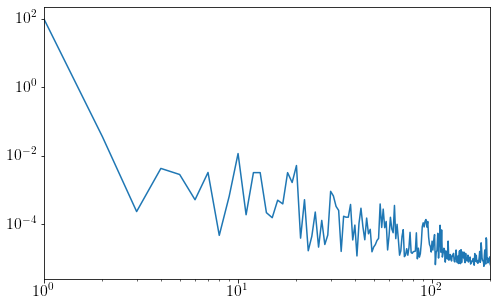

In [160]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(lmax+1)+1, spectrum)
plt.yscale('log');plt.xscale('log')
plt.xlim(1,lmax)

In [154]:
def loglike(l, Cl, params, grad=False):
    if not grad:
        x = (2*l+1)*Cl / model(l, params)
        lnl = np.sum( (l-0.5)*np.log(x)-x/2 )
        if np.isnan(lnl): print(params)
        return lnl
    else: 
        mod_vals, mod_grad = model(l, params, grad=grad)
        x = (2*l+1)*Cl / mod_vals
        x_prime = -(2*l+1)*Cl / mod_vals**2 * mod_grad
        lnl_val = np.sum( (l-0.5)*np.log(x)-x/2 )
        lnl_grad = np.sum( x_prime * ((l-0.5)/x - 1/2) , axis=1)
        
        return lnl_val, lnl_grad
    
def model(l, params, grad=False):
    A = np.exp(params[0])
    gamma=params[1]
    mod_vals = A*(l+1)**gamma
    if not grad: return mod_vals
    mod_grad = np.array([A*(l+1)**gamma,
                         A*(l+1)**gamma * np.log(l+1)])
    return mod_vals, mod_grad

In [157]:
lmax_fit=135
lvals = np.arange(lmax+1)

fits = np.zeros((M,C,2))
for iM in range(M):
    for iC in range(C):
        spectrum = hp.anafast(x[iM,iC], lmax=lmax)

        def nll(x):
            lnl, lnl_grad = loglike(lvals[:lmax_fit], spectrum[:lmax_fit], x, grad=True)
            return -lnl, -lnl_grad

        result= scipy.optimize.minimize(nll, np.array([0.,-2.]), method='Newton-CG', jac=True, options={'maxiter':1000})
        fits[iM,iC] = result['x']

/home/andy/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/home/andy/py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/andy/py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the CWD from sys.path while we load stuff.
/home/andy/py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in subtract
  # This is added back by InteractiveShellApp.init_path()
/home/andy/py36/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in true_divide
  if __name__ == '__main__':
/home/andy/py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in true_divide
  # Remove the CWD from sys.path while we 

In [158]:
fits

array([[[-3.47508572e+04, -1.53583784e+05],
        [-5.74667516e+04, -2.53983817e+05],
        [-7.10875023e+05, -3.14193234e+06]],

       [[-1.40672502e+01, -1.34857429e-01],
        [-1.38213513e+01, -3.06083148e-01],
        [-2.56991379e+05, -1.13584739e+06]],

       [[-1.27555537e+01, -1.72280541e-01],
        [-1.17719320e+01, -5.04171083e-01],
        [-7.31268422e+04, -3.23198901e+05]],

       [[-1.10660017e+01, -3.23667708e-01],
        [-9.45246635e+00, -7.78687840e-01],
        [-1.41872958e+01, -3.07942683e-01]],

       [[-8.48190396e+00, -6.66380689e-01],
        [-7.48186578e+00, -9.89039990e-01],
        [-1.26977499e+01, -4.34921623e-01]],

       [[-5.14458819e+00, -1.16233912e+00],
        [-5.09151052e+00, -1.28299113e+00],
        [-1.03588135e+01, -7.39908545e-01]],

       [[-3.24499233e+00, -1.40303047e+00],
        [-2.58621637e+00, -1.68864137e+00],
        [-8.18986474e+00, -1.00238795e+00]],

       [[-2.06751907e+00, -1.57225421e+00],
        [-7.812549

(1, 200)

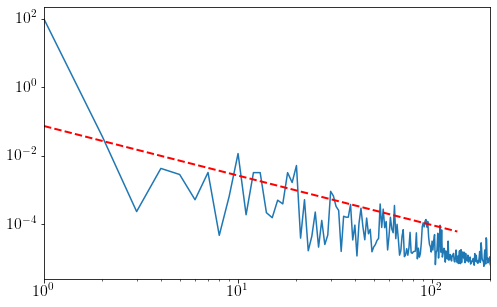

In [161]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(lmax+1)+1, spectrum)
plt.yscale('log');plt.xscale('log')
plt.plot(np.arange(lmax_fit)+1, model(np.arange(lmax_fit), fits[iM,iC]),  '--r', linewidth=2)
plt.xlim(1,lmax)

In [83]:
fits[iM,iC]

array([ -35882.5899454 , -158585.86518836])

In [84]:
model(np.arange(lmax_fit), fits[iM,iC])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [164]:
x = logit((np.sum(box['k'], axis=(0,1))+1)/(np.sum(box['n'], axis=(0,1))+2))
spectrum = hp.anafast(x, lmax=lmax)

def nll(x):
    lnl, lnl_grad = loglike(lvals[:lmax_fit], spectrum[:lmax_fit], x, grad=True)
    return -lnl, -lnl_grad

result= scipy.optimize.minimize(nll, np.array([0.,-2.]), method='Newton-CG', jac=True, options={'maxiter':1000})

In [165]:
result

     fun: -33183.94442292953
     jac: array([-0.44003907, -0.90846507])
 message: 'Optimization terminated successfully.'
    nfev: 8
    nhev: 0
     nit: 6
    njev: 18
  status: 0
 success: True
       x: array([-0.21412955, -2.22593792])